# Nanodegree Engenheiro de Machine Learning
## Projeto final
Gabriel Yan Mitoso

20 de Outubro de 2018

## Explorando os Dados
Nesta seção, vamos explorar e analisar os dados através de visualizações e códigos.

In [1]:
import numpy as np
import pandas as pd

crime_data = pd.read_csv("data/crime-occurrence-SP-2015-2017.csv", sep=";")

print(crime_data.head())

   UF  Código IBGE Município   Município        Tipo Crime  Mês   Ano  \
0  SP                3500105  Adamantina           Estupro    1  2015   
1  SP                3500105  Adamantina           Estupro    2  2015   
2  SP                3500105  Adamantina           Estupro   11  2015   
3  SP                3500105  Adamantina  Furto de ve�culo    2  2015   
4  SP                3500105  Adamantina  Furto de ve�culo    3  2015   

   Qtde Ocorrências  
0                 1  
1                 1  
2                 1  
3                 1  
4                 2  


In [2]:
# Número de ocorrências
n_crimes = crime_data.shape[0]

# Número de atributos
n_features = crime_data.shape[1]

# Número de categorias
categories = crime_data["Tipo Crime"].unique()
n_categories = categories.size

# Número de cidades
cities = crime_data["Código IBGE Município"].unique()
n_cities = cities.size

print "Número total de ocorrências: {}".format(n_crimes)
print "Número de atributos: {}".format(n_features)
print "Número de categorias de crime: {}".format(n_categories)
print "Número de cidades: {}".format(n_cities)

Número total de ocorrências: 24550
Número de atributos: 7
Número de categorias de crime: 6
Número de cidades: 626


## Visualização exploratória
Nesta seção, vamos gerar diferentes histogramas e analisá-los.

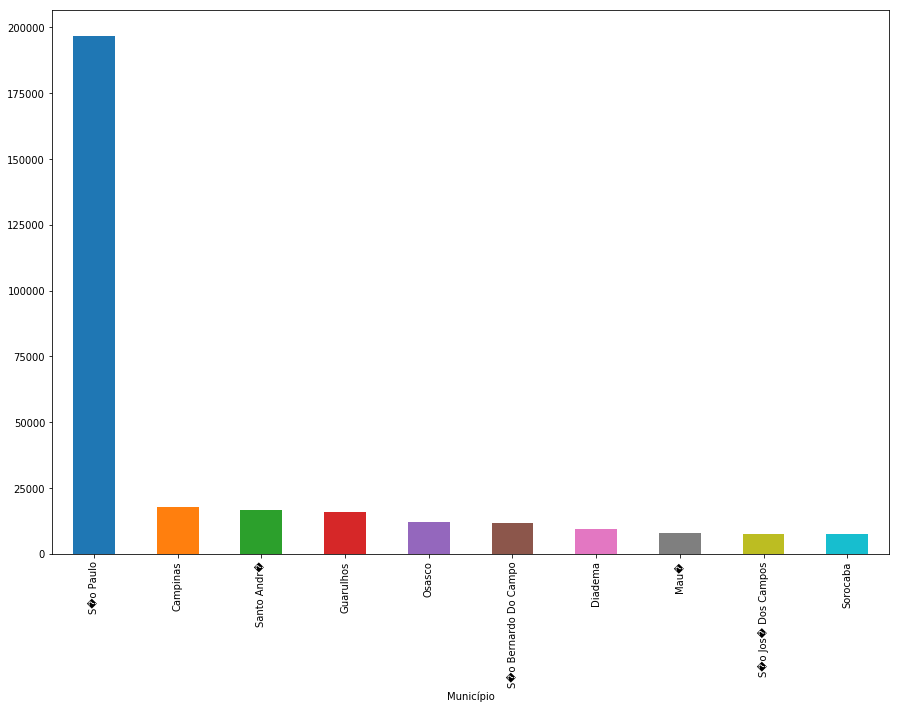

In [6]:
import matplotlib.pyplot as pl

# Gráfico com as 10 cidades com maior número ocorrências
top_cities = crime_data.groupby(['Município'])['Qtde Ocorrências'].agg('sum').sort_values(ascending=False)
top_cities[:10].plot(kind='bar', figsize=(15,10))
pl.savefig('images/top_cities.png')

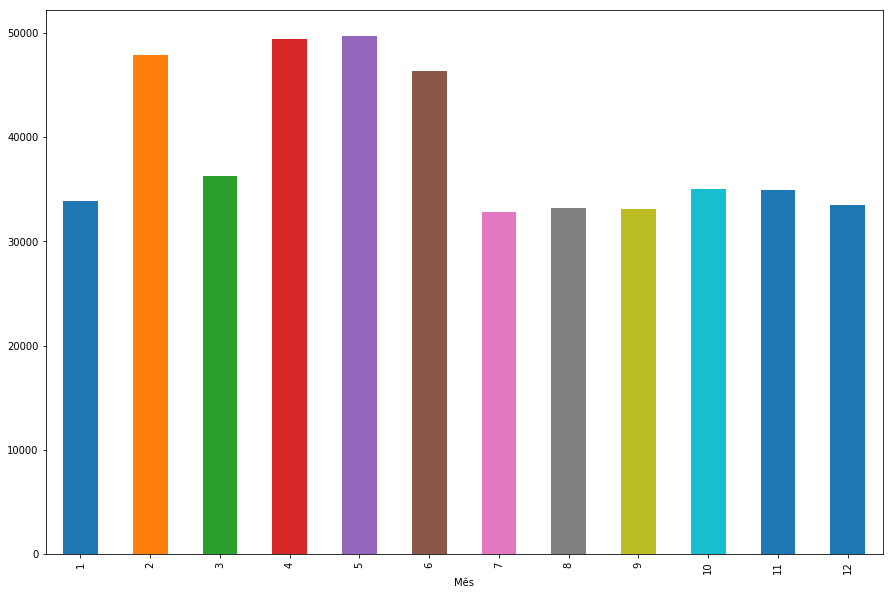

In [5]:
# Gráfico com  número de ocorrências por mês
registers_months = crime_data.groupby(['Mês'])['Qtde Ocorrências'].agg('sum')
registers_months.plot(kind='bar', figsize=(15,10))
pl.savefig('images/registers_months.png')

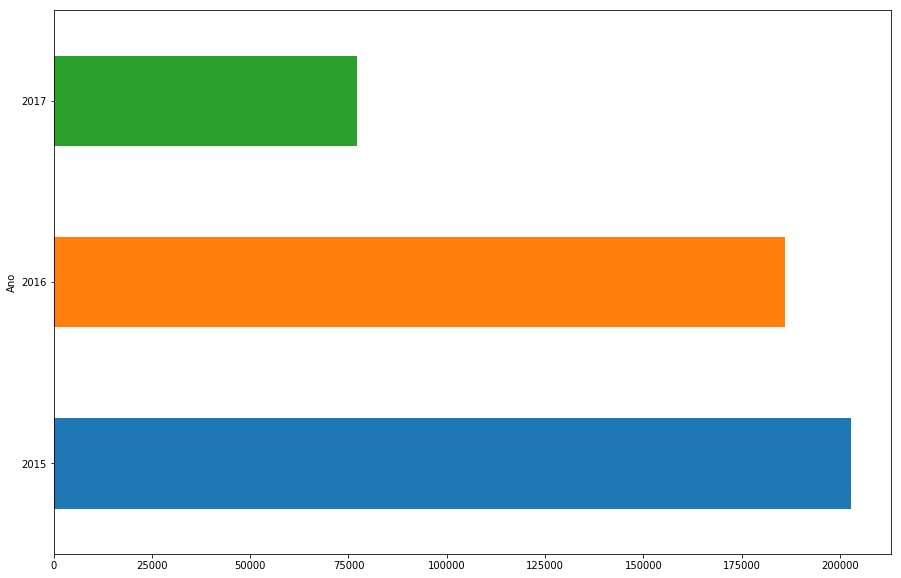

In [7]:
# Gráfico com  número de ocorrências por ano
registers_years = crime_data.groupby(['Ano'])['Qtde Ocorrências'].agg('sum')
registers_years.plot(kind='barh', figsize=(15,10))
pl.savefig('images/registers_years.png')

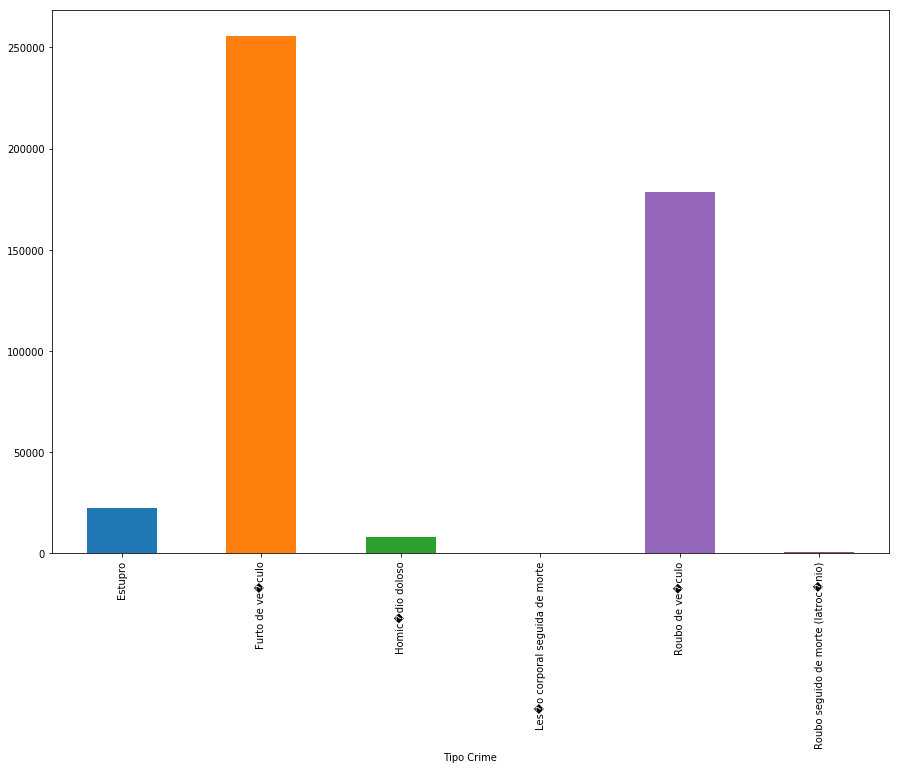

In [8]:
# Gráfico com o número de ocorrências por categoria de crime
top_crimes = crime_data.groupby(['Tipo Crime'])['Qtde Ocorrências'].agg('sum')
top_crimes.plot(kind='bar', figsize=(15,10))
pl.savefig('images/top_crimes.png')

## Pré-processamento de dados
Nesta seção, vamos identificar e analisar possíveis outliers, assim como transformar dados não numéricos para facilitar o processamento.

In [3]:
# Remove linhas sem categorias
crime_data.dropna(subset=["Tipo Crime"], inplace=True)

# Substitui as categorias por números
data_dict = {}
count = 1
for data in categories:
    data_dict[data] = count
    count+=1
crime_data["Tipo Crime"] = crime_data["Tipo Crime"].replace(data_dict)

# Remove as colunas UF e Município
crime_data.drop(columns=['UF', 'Município'], inplace=True)

print(crime_data.head())

   Código IBGE Município  Tipo Crime  Mês   Ano  Qtde Ocorrências
0                3500105           1    1  2015                 1
1                3500105           1    2  2015                 1
2                3500105           1   11  2015                 1
3                3500105           2    2  2015                 1
4                3500105           2    3  2015                 2


In [5]:
from sklearn.cross_validation import train_test_split

features = crime_data.drop(columns=['Tipo Crime'])
target = crime_data["Tipo Crime"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=23)

## Implementação
Nesta seção, vamos implementar os algoritmos de K-Nearest Neighbors e Regressão Logística, utilizando Log Loss como métrica.

In [7]:
from collections import OrderedDict
data_dict_new = OrderedDict(sorted(data_dict.items()))

# função para retornar no formato que a métrica log loss irá utilizar
def resultFrame(predictions):
    result_dataframe = pd.DataFrame({
        "Id": X_test["Código IBGE Município"]
    })
    for key,value in data_dict_new.items():
        result_dataframe[key] = 0
    count = 0
    for item in predictions:
        for key,value in data_dict.items():
            if(value == item):
                result_dataframe[key][count] = 1
        count+=1
    return result_dataframe

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
resultFrameKnn = resultFrame(predictions)

print "KNN Pontuação F1: {}".format(f1_score(y_test.values, predictions, average='weighted'))
print "KNN Acurácia: {}".format(accuracy_score(y_test.values, predictions))

KNN Pontuação F1: 0.451454935708
KNN Acurácia: 0.456822810591


In [23]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, y_train)
predictions = log.predict(X_test)
resultFrameLog = resultFrame(predictions)

print "Log Pontuação F1: {}".format(f1_score(y_test.values, predictions, average='weighted'))
print "Log Acurácia: {}".format(accuracy_score(y_test.values, predictions))

Log Pontuação F1: 0.191974615632
Log Acurácia: 0.36150712831


In [11]:
from sklearn.metrics import log_loss

print "KNN Log Loss: {}".format(log_loss(y_test.values, resultFrameKnn.drop(columns=['Id'])))
print "Logistic Regression Log Loss: {}".format(log_loss(y_test.values, resultFrameLog.drop(columns=['Id'])))

KNN Log Loss: 1.79842892278
Logistic Regression Log Loss: 1.79175946923


## Refinamento
Nesta seção, vamos otimizar os algoritmos de K-Nearest Neighbors e Regressão Logística.

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

parametersLog = {'tol': [1e-3, 1e-4, 1e-5, 1e-6], 'C': [1, 10, 100, 1000]}
parametersKnn = {'n_neighbors': [3, 4, 5, 6], 'weights': ['uniform', 'distance']}

f1_scorer = make_scorer(f1_score, average='weighted')

grid_knn = GridSearchCV(knn, parametersKnn, scoring=f1_scorer)
grid_knn = grid_knn.fit(X_train, y_train)
knn = grid_knn.best_estimator_
predictions = knn.predict(X_test)
resultFrameKnn = resultFrame(predictions)

grid_log = GridSearchCV(log, parametersLog, scoring=f1_scorer)
grid_log = grid_log.fit(X_train, y_train)
log = grid_log.best_estimator_
predictions = log.predict(X_test)
resultFrameLog = resultFrame(predictions)

print "KNN calibrado Log Loss: {}".format(log_loss(y_test.values, resultFrameKnn.drop(columns=['Id'])))
print "Logistic Regression calibrado Log Loss: {}".format(log_loss(y_test.values, resultFrameLog.drop(columns=['Id'])))

KNN calibrado Log Loss: 1.79842892278
Logistic Regression calibrado Log Loss: 1.79175946923
